# Model to Evaluate

In [23]:
# model_params = "../data/bestmodel_unfrozen_20ng2000_noparams.pt"
model_params = "../data/bestmodelP1.0_unfrozen_movies_2.pt"

### Installs, Imports, and Pyro Setup 

In [24]:
! source activate pytorch_env

In [28]:
import pickle as pkl
from typing import List
from imdb_dataset import PairwiseData, DocumentPairData
from model import Encoder, Decoder, ProdLDA, custom_elbo
import math

import numpy as np
import torch
import graphviz
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from ctt.clean import kitchen_sink

import pyro
from pyro import poutine
import pyro.distributions as dist
# import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam
import torch.nn.functional as F
from scipy.io import loadmat

import scipy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import wandb
import umap
import umap.plot
import sklearn.datasets
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score

plt.rcParams["figure.figsize"] = (10,5)

In [29]:
pyro.distributions.enable_validation(True)

In [30]:
pyro.set_rng_seed(0)

# Setup

In [31]:
# Data
PAIR_PERCENTAGE = 1.0
NUM_WORKERS = 0

# Dropout rate
NUM_TOPICS = 50
NUM_PROTOTYPES = 7
EMBED_DIM  = 64
HIDDEN_DIM = 128
DROPOUT_RATE = 0.2

# Training
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 25
TEST_FREQUENCY = 1
BATCH_SIZE = 128
VAL_BATCH_SIZE = 2000
OBS_SAMPLES = 10

latest_plotted_p = torch.zeros(NUM_PROTOTYPES, NUM_TOPICS)

## Data

In [32]:
# pairwise data
pwd = PairwiseData()
train_pairs, val_pairs, test_pairs = [pwd.get_pairs_table(d) for d in [pwd.train, pwd.val, pwd.test]]

# datasets
data_train, data_val, data_test = [
    DocumentPairData(bows=pwd.bows, index_table=ix_table, prob=PAIR_PERCENTAGE)
    for ix_table in [train_pairs, val_pairs, test_pairs]
]

# dataloaders
dl_train = DataLoader(data_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
dl_val = DataLoader(data_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
dl_test = DataLoader(data_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

## Training 

In [33]:
def evaluate(etm, test_loader, device): 
    etm.eval()
    
    # initialize loss accumulator
    logits_list = []
    labels_list = []
    
    # compute the loss over the entire test set
    for x in test_loader:
        # if on GPU put mini-batch into CUDA memory
        x_a = x['a'].to(device).squeeze()
        x_b = x['b'].to(device).squeeze()
        x_label = x['label'].to(device).type(torch.float32)
        x_observed = x['observed'].to(device).type(torch.bool)
        
        # generate reconstruction of batch documents and move to cuda if designated
        with torch.no_grad():
            recon_x_a = etm.reconstruct_doc(x_a)
            recon_x_b = etm.reconstruct_doc(x_b)
            logits = etm.guide(x_a, x_b, x_label, x_observed)

        x_label = x_label.cpu()
        logits_list.append(logits.cpu())
        labels_list.append(x_label)
        
#         # do something with the log odds
    return torch.concat(logits_list), torch.concat(labels_list)

In [34]:
# clear param store
pyro.clear_param_store()
# setup the VAE
topic_model = ProdLDA(pwd.vocab_size, NUM_TOPICS, NUM_PROTOTYPES, HIDDEN_DIM, DROPOUT_RATE, DEVICE, frozen=True).to(DEVICE)

saved_model_dict = torch.load(model_params)
topic_model.load_state_dict(saved_model_dict['model'])

<All keys matched successfully>

In [ ]:
accuracy = {}
with torch.no_grad():
    logits, label = evaluate(topic_model, dl_test, device=DEVICE)
logits = torch.sigmoid(logits)
for threshold in np.arange(0,1,0.05):
    threshold = round(threshold,3)
    logits_binned = np.digitize(logits, [threshold], right=False)
    acc = accuracy_score(label, logits_binned)
    accuracy[threshold] = acc

Text(0.5, 1.0, 'Accuracy vs Threshold (with baselines)')

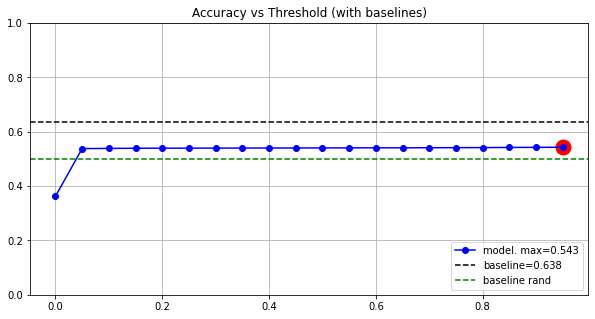

In [36]:
acc_threshold = list(accuracy.keys())
acc_acc = list(accuracy.values())
acc_baseline = accuracy_score(torch.zeros_like(label), label)
acc_rand = accuracy_score(torch.randint_like(label, 2), label)
acc_max = max(acc_acc)
acc_max_ix = np.argmax(acc_acc)

plt.plot(acc_threshold, acc_acc, 'bo-', label=f'model. max={acc_max:0.3f}')
plt.scatter(x=acc_threshold[acc_max_ix], y=acc_max, color='r', marker='o', linewidth=10)
plt.axhline(y=acc_baseline, color='k', linestyle='--', label=f'baseline={acc_baseline:0.3f}')
plt.axhline(y=acc_rand, color='g', linestyle='--', label='baseline rand')
plt.ylim(0,1)
plt.grid()
plt.legend(loc=4)
plt.title("Accuracy vs Threshold (with baselines)")

Text(0.5, 1.0, 'Precision vs Recall (with baseline)')

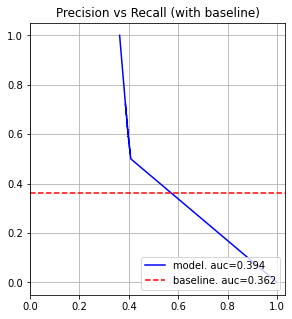

In [37]:
prec, rec, _ = precision_recall_curve(label.numpy().astype(int), logits)
auc_precrec = average_precision_score(label.numpy().astype(int), logits)
baseline_prec = label.mean()

plt.plot(prec, rec, 'b-', label=f'model. auc={auc_precrec:0.3f}')
plt.axhline(y=baseline_prec, color='r', linestyle='--', label=f'baseline. auc={baseline_prec:0.3f}')
# plt.axhline(y=acc_rand, color='g', linestyle='--', label='baseline rand')
# plt.ylim(0,1.1)
plt.xlim(0,None)
plt.gca().set_aspect(1)
plt.grid()
plt.legend(loc=4)
plt.title("Precision vs Recall (with baseline)")

Text(0.5, 1.0, 'ROC Curve (with baseline); AUROC = 0.5497')

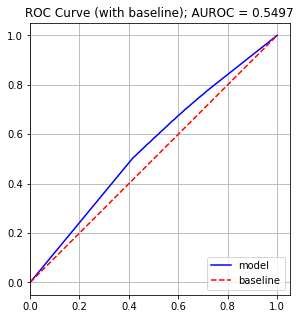

In [38]:
fpr, tpr, _ = roc_curve(label.numpy().astype(int), logits)
auroc = roc_auc_score(label,logits)

plt.plot(fpr, tpr, 'b-', label='model')
plt.plot(fpr, fpr, color='r', linestyle='--', label='baseline')
plt.xlim(0,None)
plt.gca().set_aspect(1)
plt.grid()
plt.legend(loc=4)
plt.title(f"ROC Curve (with baseline); AUROC = {round(auroc,4)}")

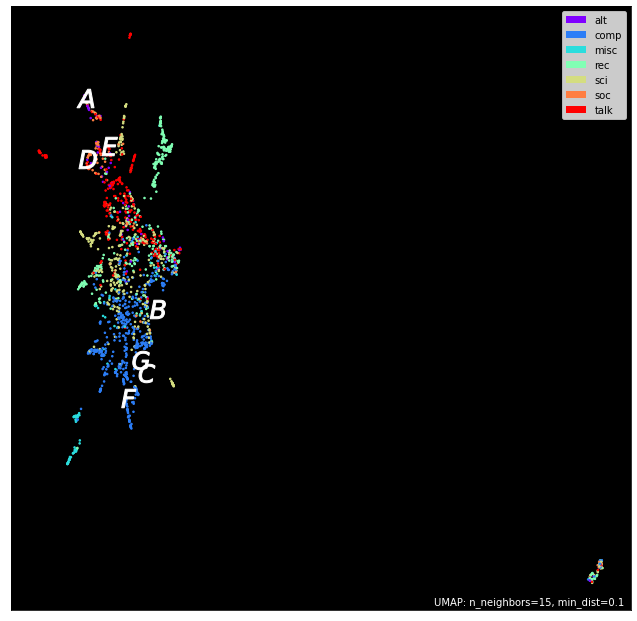

In [22]:
x = torch.tensor(pwd.bows_val.toarray()).to(DEVICE).type(torch.float)
with torch.no_grad():
    z_loc, z_scale = topic_model.encoder(x)

features = z_loc.cpu()
features = torch.softmax(features, axis=-1)
features = features.numpy()

trans = umap.UMAP(n_neighbors=15, random_state=42, min_dist=0.1).fit(features)
p = pyro.param('p').detach().cpu()
phi = torch.softmax(p, axis=-1)
p_2d = trans.transform(p)
umap.plot.points(trans, labels=pwd.val.category,theme='fire')
for ix, marker in enumerate(['$A$', '$B$', '$C$', '$D$', '$E$', '$F$', '$G$']):
    plt.scatter(x=p_2d[ix,0], y=p_2d[ix,1], s=7**3, c='white', marker=marker)

In [15]:
tok2ix = pwd.vectorizer.vocabulary_
ix2tok = {v:k for k,v in tok2ix.items()}
with torch.no_grad():
    phi_decoded = topic_model.decoder(phi.to(DEVICE))
top_term_ixs = phi_decoded.argsort(axis=-1, descending=True)[:,:15]

topic_terms = []
for jx, topic in enumerate(top_term_ixs):
    # print(f"THEME {jx+1}")
    terms = [ix2tok[ix.item()] for ix in topic]
    # for term in terms:
        # print(term)
    topic_terms.append(terms)
    # print()
    
df = pd.DataFrame(topic_terms)
df = df.transpose()
df.columns = ["Theme A", "Theme B", "Theme C", "Theme D", "Theme E", "Theme F", "Theme G"]
df.style.hide_index()

Theme A,Theme B,Theme C,Theme D,Theme E,Theme F,Theme G
bike,window,john,get,also,game,may
check,home,games,look,pub,look,would
short,running,best,back,name,get,good
parts,set,great,name,receive,mr,also
wide,lib,game,like,written,last,well
easy,usr,last,next,ftp,good,help
front,problem,sent,end,author,go,one
break,display,like,use,dr,like,time
road,screen,good,later,may,would,like
needed,help,posted,open,information,ms,get
